In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import matplotlib.pyplot as plt
import copy
import itertools
from utils_graphs import select_significant_areas, create_graph, plot_graph

In [2]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_c57.npy', allow_pickle=True).item()
subjects = list(dict_results_across_mice.keys())
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_ncells_ttest = select_significant_areas(df=df_ttest_not_null_ncells, threshold=0.05)
sig_areas_ncells_mannwhitneyu = select_significant_areas(df=df_mannwhitneyu_not_null_ncells, threshold=0.05)
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

In [4]:
corr_threshold = 0.75
allen_order = list(volumes[volumes['st_level']==8]['acronym'])

In [5]:
G_control = create_graph(corr_matrix_control_ncells, volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold)
G_fam = create_graph(corr_matrix_fam_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold)
G_unfam = create_graph(corr_matrix_unfam_ncells,  volumes=volumes, 
                         significant_areas=sig_areas_ncells_ttest, 
                         corr_threshold=corr_threshold)

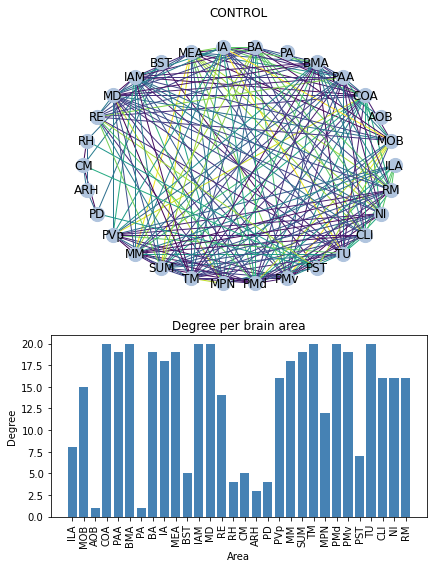

In [15]:
fig = plt.figure("control", figsize=(6, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
plot_graph(G=G_control,order=allen_order, ax=ax0, title='CONTROL')

areas = sorted(list(G_control.nodes()), key = allen_order.index)
degrees = [G_control.degree()[area] for area in areas]
ax1 = fig.add_subplot(axgrid[3:, :])
ax1.bar(x= areas, 
        height= degrees,
       color='steelblue')
ax1.set_title("Degree per brain area")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Area")
ax1.tick_params(axis='x', labelrotation=90)

fig.tight_layout()
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graph_control.svg')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graph_control.png')

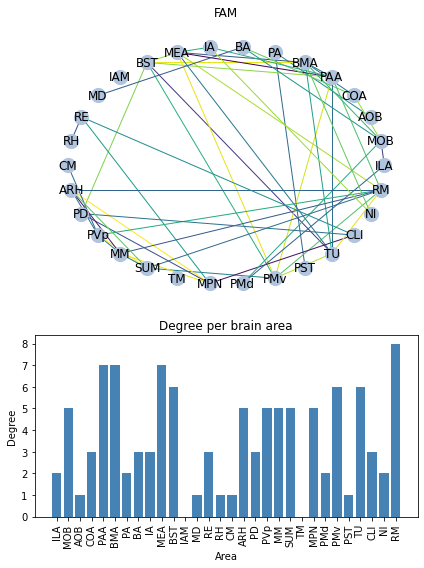

In [16]:
fig = plt.figure("fam", figsize=(6, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
plot_graph(G=G_fam,order=allen_order, ax=ax0, title='FAM')

areas = sorted(list(G_fam.nodes()), key = allen_order.index)
degrees = [G_fam.degree()[area] for area in areas]
ax1 = fig.add_subplot(axgrid[3:, :])
ax1.bar(x= areas, 
        height= degrees,
       color='steelblue')
ax1.set_title("Degree per brain area")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Area")
ax1.tick_params(axis='x', labelrotation=90)

fig.tight_layout()
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graph_fam.svg')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graph_fam.png')

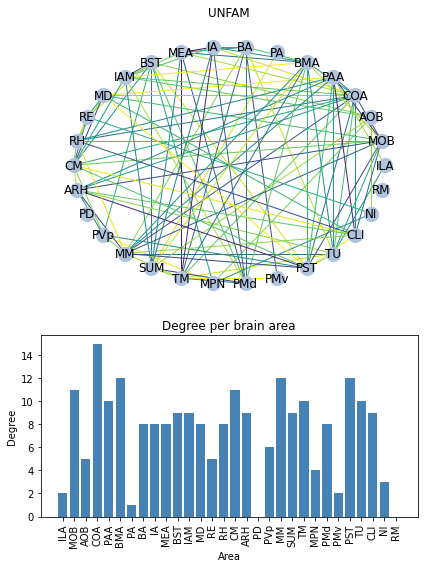

In [17]:
fig = plt.figure("unfam", figsize=(6, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
plot_graph(G=G_unfam,order=allen_order, ax=ax0, title='UNFAM')

areas = sorted(list(G_unfam.nodes()), key = allen_order.index)
degrees = [G_unfam.degree()[area] for area in areas]
ax1 = fig.add_subplot(axgrid[3:, :])
ax1.bar(x= areas, 
        height= degrees,
       color='steelblue')
ax1.set_title("Degree per brain area")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Area")
ax1.tick_params(axis='x', labelrotation=90)

fig.tight_layout()
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graph_unfam.svg')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/graph_unfam.png')

# Histogram degrees

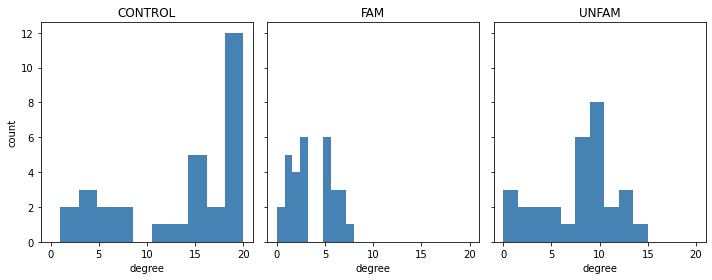

In [18]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
axes[0].set_title('CONTROL')
axes[0].hist(list(dict(G_control.degree).values()),
            color='steelblue')
axes[1].set_title('FAM')
axes[1].hist(list(dict(G_fam.degree).values()),
            color='steelblue')
axes[2].set_title('UNFAM')
axes[2].hist(list(dict(G_unfam.degree).values()),
            color='steelblue')
for i in range(3):
    axes[i].set_xlabel('degree')
axes[0].set_ylabel('count')
plt.tight_layout()
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_degree.svg')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_degree.png')

# Histogram weights

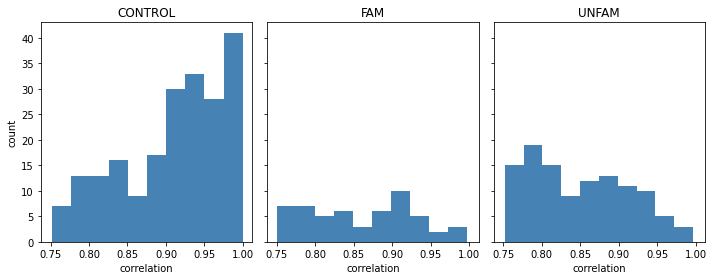

In [19]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
for i, G in enumerate([G_control, G_fam, G_unfam]):
    axes[i].hist([G[u][v]['weight'] for u, v in G.edges],
            color='steelblue')
axes[0].set_title('CONTROL')
axes[1].set_title('FAM')
axes[2].set_title('UNFAM')
for i in range(3):
    axes[i].set_xlabel('correlation')
axes[0].set_ylabel('count')
plt.tight_layout()
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation.svg')
plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation.png')

In [34]:

ordered_areas = sorted(sig_areas_ncells_ttest, 
                       key = list(volumes[volumes['st_level']==8]['safe_name'])
.index)
dictionary_labels = {volumes.loc[volumes['safe_name'] == area]['acronym'].values[0]:area\
                     for area in ordered_areas}
df_areas = pd.DataFrame.from_dict(dictionary_labels, orient='index')
df_areas.columns = ['area']
df_areas.to_csv('significant_areas.csv')